<a href="https://colab.research.google.com/github/Amro97/Amro/blob/master/Neural_Style_Transfer_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural style transfer

**Presented to you by:** ***AmRo HaBiB***

# ***In this project we will observe the following:***

***1)*** non-optimal optimization & optimal Content/Style weights balance.   
***2)*** optimal optimization & non-optimal Content/Style weights balance.   
***3)*** optimal optimization & optimal Content/Style weights balance, which then we will include:      
  ***3.1)*** a comparsion between 2 different sets of layers, so   we can observe the outcome.

each observation will conclude 3 stages:   
***a***) 2-3 epochs training to see that implementation is working (badly balanced factors may not show serious results).  
***b)*** a serious training of 10 epochs and each epoch has 100 steps, so we can actually obeserve the final outcome.  
***c)*** final stage, which will include extra function, to smoothen our image, and minimize noise, AKA Variation-loss.

note: variation-loss weight will be the same for all experiments, since it doesn't affect effect the actual values of outcome, but smoothens it, so its better be seen in the same level for all.

## Setup


### Import and configure modules

In [1]:
import tensorflow as tf

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

tensor to image function, is useless here, but still included to  make our results more "beautiful"...

In [3]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [4]:
content_path = ('content.jpeg')
style_path = ('style.jpg')

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [6]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

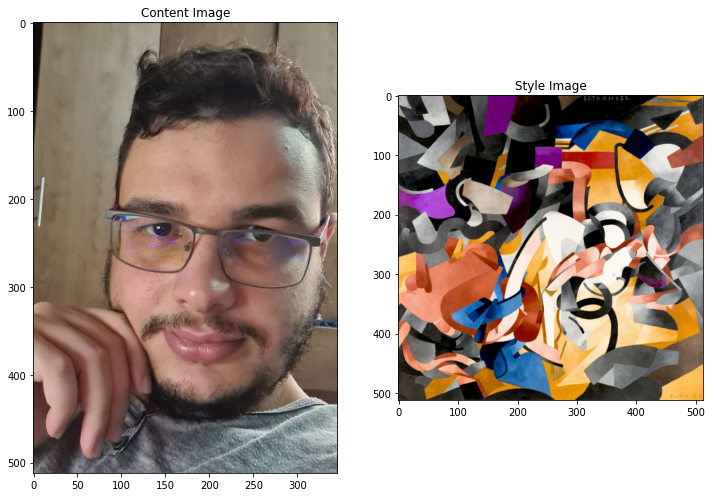

In [7]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

 brief visualization of what we are going to do throughout this project, so I used an algorithm that will do the job for us in 1 click.

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub](https://tensorflow.org/hub) module does:

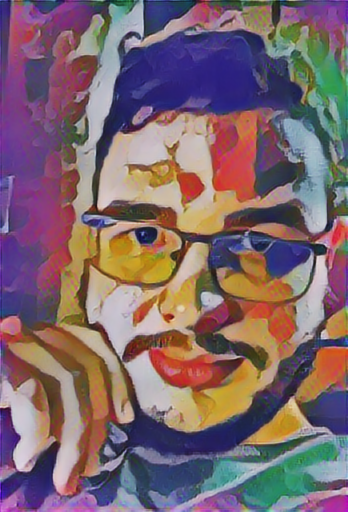

In [8]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

## Define content and style representations

Use the intermediate layers of the model to get the *content* and *style* representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, I'm using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/applications/#vgg19) and test run it on our image to ensure it's used correctly:

In [9]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

Now load a `VGG19` without the classification head, and list the layer names

In [10]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [12]:
def vgg_layers(layer_names):
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [16]:
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image:

In [18]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Calculating both style-loss & content-loss, and then total loss as given in the class but with the use of TensorFlow functions:

In [20]:
def style_content_loss(outputs, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

# Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts (AKA noise). Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

In [21]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

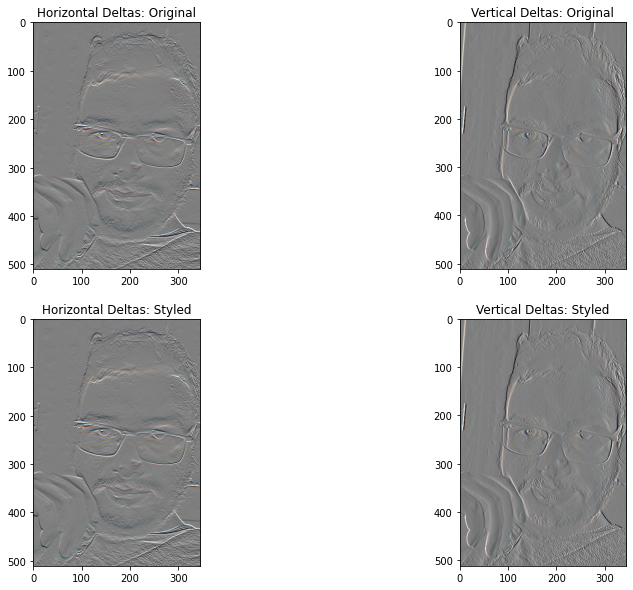

In [22]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

The regularization loss associated with this is the sum of the squares of the values:

In [23]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

train_step is the optimization & training ***without*** variation loss.

In [24]:
def train_step(image):
  #Use `tf.GradientTape` to update the image
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_weight, content_weight)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Choose a weight for the "total_variation_loss"

In [25]:
total_variation_weight=30

smoother_train_step is the optimization & training function with variation loss included

In [26]:
def smoother_train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_weight, content_weight)
    #adding variation loss to the total loss function
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# ***Experiment #1 bad opt & good weight balancing.***



creating an optimizer, I chose Adam to work with

In [27]:
opt = tf.optimizers.Adam(learning_rate=2, beta_1=0.5, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [28]:
style_weight=0.01
content_weight=10000

***Stage #1 few steps to test:***

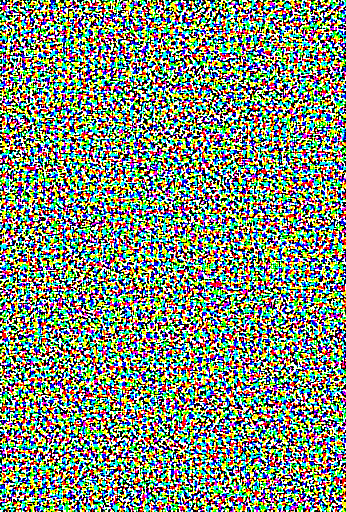

In [29]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

***Stage #2 perform a longer optimization without variation-loss:***

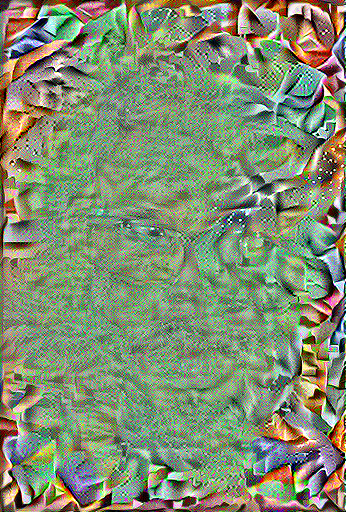

Train step: 1000
Total time: 120.9


In [30]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

***Stage #3 Re-run the optimization with variation loss included***

Reinitializing the optimization variables, so our data doesn't get messed up:

In [31]:
image = tf.Variable(content_image)

And run the optimization:

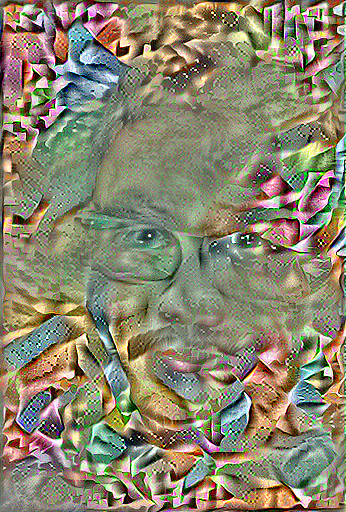

Train step: 1000
Total time: 122.3


In [32]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    smoother_train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# ***Experiment #2 good opt & bad weight balancing (lower style, higher content).***

In [33]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=0.000001
content_weight=1000000

Reinitializing the optimization variables, so our data doesn't get messed up:

In [34]:
image = tf.Variable(content_image)

***Stage #1 few steps to test:***

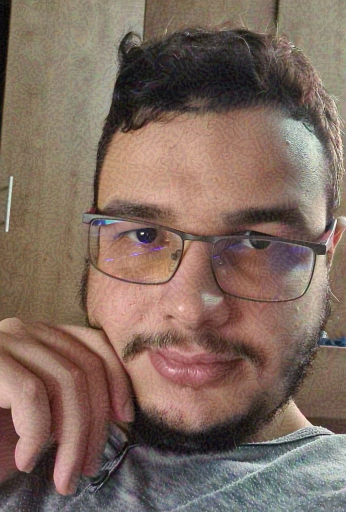

In [35]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

***Stage #2 perform a longer optimization without variation-loss:***

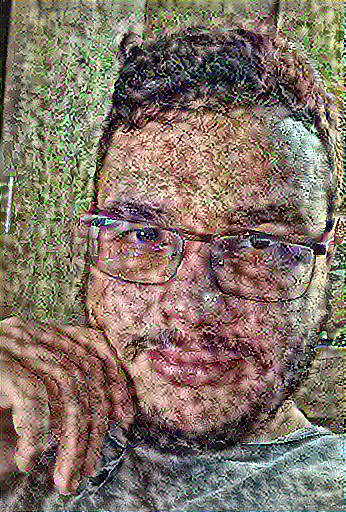

Train step: 1000
Total time: 119.9


In [36]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

***Stage #3 Re-run the optimization with variation loss included***

In [37]:
image = tf.Variable(content_image)

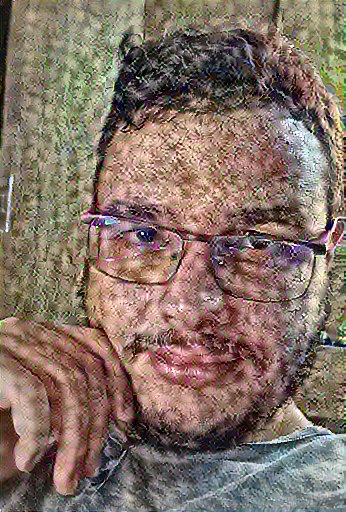

Train step: 1000
Total time: 121.8


In [38]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    smoother_train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# ***Experiment #3 good opt & bad weight balancing (higher style, lower content).***

In [39]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=10000
content_weight=0.00001

Reinitializing the optimization variables, so our data doesn't get messed up:

In [40]:
image = tf.Variable(content_image)

***Stage #1 few steps to test:***

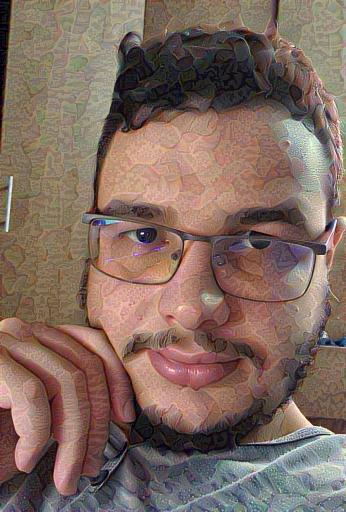

In [41]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

***Stage #2 perform a longer optimization without variation-loss:***

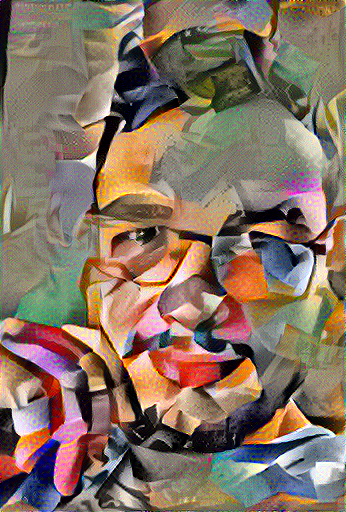

Train step: 1000
Total time: 119.7


In [42]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

***Stage #3 Re-run the optimization with variation loss included***

In [43]:
image = tf.Variable(content_image)

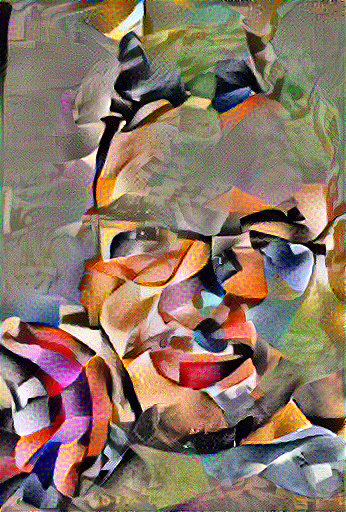

Train step: 1000
Total time: 121.8


In [44]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    smoother_train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# ***Experiment #4 optimal opt & optimal weight balancing.***

In [45]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=0.01
content_weight=10000

Reinitializing the optimization variables, so our data doesn't get messed up:

In [46]:
image = tf.Variable(content_image)

***Stage #1 few steps to test:***

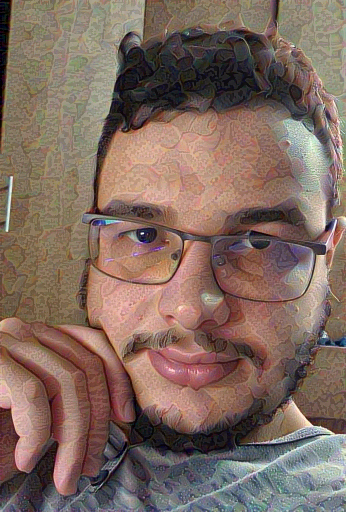

In [47]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

***Stage #2 perform a longer optimization without variation-loss:***

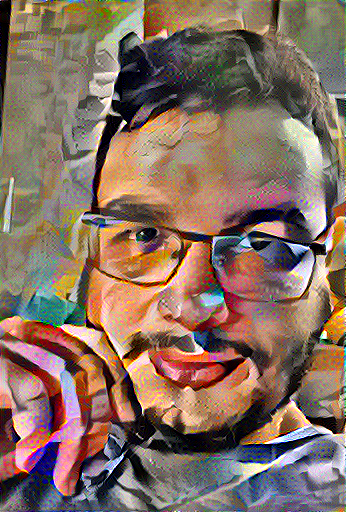

Train step: 1000
Total time: 119.8


In [48]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

***Stage #3 Re-run the optimization with variation loss included***

In [49]:
image = tf.Variable(content_image)

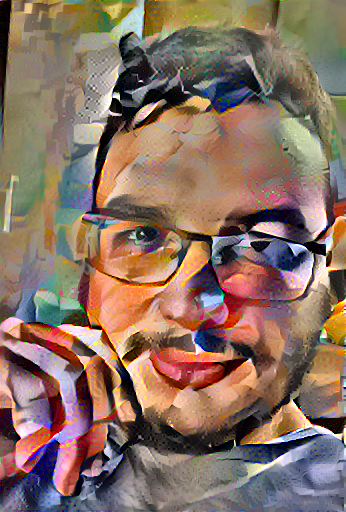

Train step: 1000
Total time: 121.9


In [50]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    smoother_train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# ***Experiment #4.1 optimal opt & optimal weight balancing, with different set of layers.***

In [51]:
content_layers = ['block5_conv4'] 

style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv3', 
                'block4_conv3', 
                'block5_conv3']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [52]:
#creating model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#extracting content & style, from the model we created
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

#extracting the targets in GRAM-MATRIX style (style&content layers we chose earlier)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Now after changing our settings and configurations, we're back to opt&training

In [53]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=0.01
content_weight=10000

Reinitializing the optimization variables, so our data doesn't get messed up:

In [54]:
image = tf.Variable(content_image)

***Stage #1 few steps to test:***

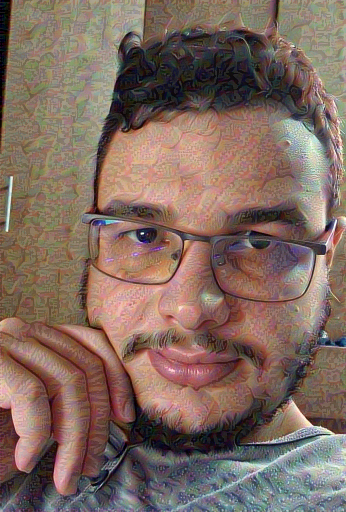

In [55]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

***Stage #2 perform a longer optimization without variation-loss:***

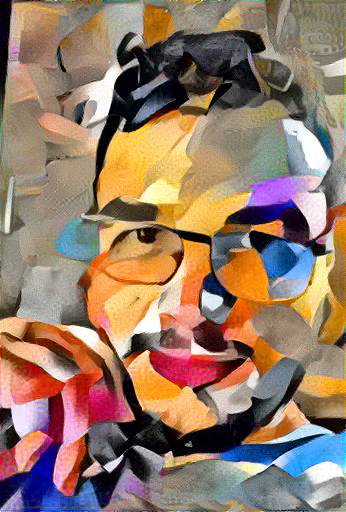

Train step: 1000
Total time: 127.2


In [56]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

***Stage #3 Re-run the optimization with variation loss included***

In [57]:
image = tf.Variable(content_image)

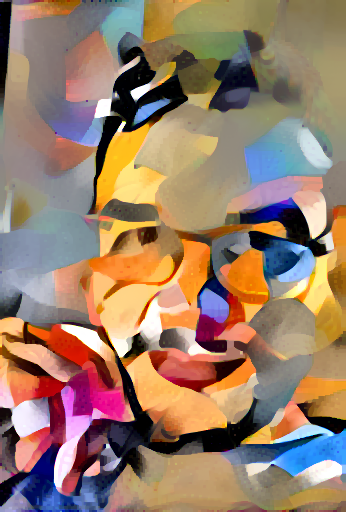

Train step: 1000
Total time: 129.4


In [58]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    smoother_train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))